# sympy_to_enzax

In [122]:
import jax
import jax.numpy as jnp
from jax import tree
from enzax import sbml
from enzax.kinetic_model import KineticModelStructure
import sympy2jax
import diffrax

jax.config.update("jax_enable_x64", True)


model_sbml = sbml.load_sbml("M:/enzax_clone/tests/data/exampleode_names.xml")
reactions_sympy = sbml.sbml_to_sympy(model_sbml)
sym_module = sbml.sympy_to_enzax(reactions_sympy)

In [132]:
parameters_all = [({p.getId(): p.getValue() for p in r.getKineticLaw().getListOfParameters()}) for r in model_sbml.getListOfReactions()]
parameters = {}
for i in parameters_all:
    parameters.update(i)
compartments ={c.getId(): c.volume for c in model_sbml.getListOfCompartments()}
species = [s.getId() for s in model_sbml.getListOfSpecies()]
y = [s.getInitialConcentration() for s in model_sbml.getListOfSpecies()]

balanced_species = {}
unbalanced_species = {}
for i in model_sbml.getListOfSpecies():
    if i.boundary_condition == False:
        balanced_species.update({i.getId(): i.getInitialConcentration()})
    else:
        unbalanced_species.update({i.getId(): i.getInitialConcentration()})

balanced_ix = jnp.array([species.index(b) for b in balanced_species])
unbalanced_ix = jnp.array([species.index(b) for b in unbalanced_species])

para = {**parameters, **compartments, **unbalanced_species}
conc = balanced_species
flux_vec = jnp.array(sym_module(**para, **conc))

stoichmatrix  = jnp.zeros((model_sbml.getNumSpecies(), model_sbml.getNumReactions()), dtype=jnp.float64)
i = 0 
for reaction in model_sbml.getListOfReactions():
    for r in reaction.getListOfReactants():
        stoichmatrix = stoichmatrix.at[species.index(r.getSpecies()), i].set(-int(r.getStoichiometry()))
    for p in reaction.getListOfProducts():
        stoichmatrix = stoichmatrix.at[species.index(p.getSpecies()), i].set(int(p.getStoichiometry()))
    i+=1

structure = KineticModelStructure(stoichmatrix, jnp.array(balanced_ix), jnp.array(unbalanced_ix))

In [ ]:
def ode_system(t, y, args):
    sym_module, para, balanced_species, structure = args
    flux_vec = jnp.array(sym_module(**para, **dict(zip(balanced_species, y))))
    sv = structure.S @ flux_vec
    return sv[structure.balanced_species]

In [ ]:
ode_func = diffrax.ODETerm(ode_system)
solver = diffrax.Tsit5()
t0, t1, dt = 0, 15, 0.1
y0 = jnp.array([2,4])

solution = diffrax.diffeqsolve(
        ode_func,
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args=(sym_module, para, balanced_species, structure),
        saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, 100)) # saves 100 timesteps 
    )

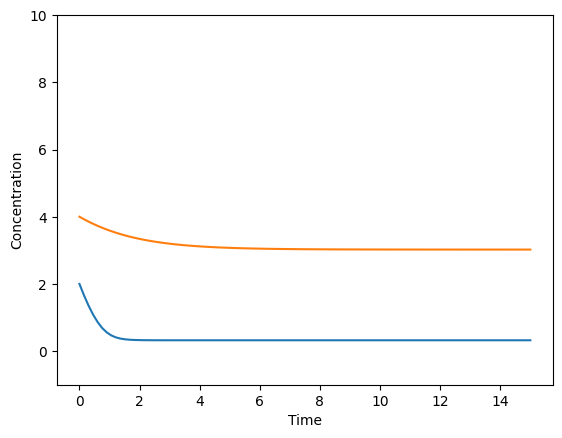

In [131]:
import matplotlib.pyplot as plt
time_points = solution.ts
species_values = solution.ys
plt.plot(time_points, species_values)

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.ylim([-1,10])
plt.show()

# Tests for sympy_to_enzax

In [ ]:
import jax.numpy as jnp
from enzax import sbml

## Example from sympy2jax 
# x_sym = sp.symbols("x_sym")
# cosx = 1.0 * sp.cos(x_sym)
# sinx = 2.0 * sp.sin(x_sym)
# mod = sympy2jax.SymbolicModule([cosx, sinx])  # PyTree of input expressions

# x = jnp.array([0,1,2])
# out = mod(x_sym=x)  # PyTree of results.
# params = tree.leaves(mod)  # 1.0 and 2.0 are parameters.
#                                # (Which may be trained in the usual way for Equinox.)

## For exampleode

# model_sbml = sbml.load_sbml("M:/enzax_clone/tests/data/exampleode.xml")
model_sbml = sbml.load_sbml("M:/Play-around-with-JAX/ExampleODE/ExampleODE_uniquenames.xml")
reactions_sympy = sbml.sbml_to_sympy(model_sbml)

mod01 = sympy2jax.SymbolicModule(reactions_sympy[0])
params01 = tree.leaves(mod01)
print(params01)

In [102]:
mod_all = sympy2jax.SymbolicModule(reactions_sympy)


In [103]:
#model_sbml.getListOfReactions()[0].getKineticLaw().getListOfParameters()
parameters = {p.getId(): p.getValue() for p in model_sbml.getListOfReactions()[0].getKineticLaw().getListOfParameters()}
parameters_all = [({p.getId(): p.getValue() for p in r.getKineticLaw().getListOfParameters()}) for r in model_sbml.getListOfReactions()]
compartments ={c.getId(): c.volume for c in model_sbml.getListOfCompartments()}
species = [s.getId() for s in model_sbml.getListOfSpecies()]
y = initial_conditions = [s.getInitialConcentration() for s in model_sbml.getListOfSpecies()]

mod01(**parameters , **compartments, **dict(zip(species, y)))

Array(0.39683213, dtype=float64, weak_type=True)

In [104]:
print(parameters_all[4])

{'Kcat_r2b': 1.0, 'Kms_r2b': 1.0, 'Kmp_r2b': 2.0, 'L0_r2b': 1.0, 'Ki_r2b': 0.9, 'Keq_r2': 7.52405}


In [ ]:
l1=parameters_all
d1={}
for i in l1:
    d1.update(i)
print (d1)

{'Kcat_r1': 0.5, 'Kms_r1': 0.5, 'Keq_r1': 25.2536, 'Kmp_r1': 1.0, 'Ki_r1': 1.0, 'Kcat_r2a': 2.0, 'Kms_r2a': 2.0, 'Kmp_r2a': 0.5, 'L0_r2a': 1.0, 'Ka_r2a': 0.3, 'Keq_r2': 7.52405, 'Kcat_r3': 2.0, 'Kms_r3': 0.5, 'Keq_r3': 2.24172, 'Kmp_r3': 2.0, 'Kcat_r4': 1.0, 'Kms_r4': 1.0, 'Keq_r4': 7.52405, 'Kmp_r4': 3.0, 'Kcat_r2b': 1.0, 'Kms_r2b': 1.0, 'Kmp_r2b': 2.0, 'L0_r2b': 1.0, 'Ki_r2b': 0.9}


In [120]:
flux_vec = jnp.array(mod_all(**d1, **compartments, **dict(zip(species, y))))

In [ ]:
stoichmatrix  = jnp.zeros((model_sbml.getNumSpecies(), model_sbml.getNumReactions()), dtype=int)
i = 0 
for reaction in model_sbml.getListOfReactions():
    for r in reaction.getListOfReactants():
        stoichmatrix = stoichmatrix.at[species.index(r.getSpecies()), i].set(-int(r.getStoichiometry()))
    for p in reaction.getListOfProducts():
        stoichmatrix = stoichmatrix.at[species.index(p.getSpecies()), i].set(int(p.getStoichiometry()))
    i+=1

In [122]:
jnp.dot(stoichmatrix, flux_vec)

Array([-3.79104723, -1.51567735,  2.10161235,  3.20511223,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ], dtype=float64)